### Cryptocurrency Time Series Forecasting: Bitcoin, Ethereum and SOL-USD

1. Data Preparation

In [ ]:
import pandas as pd
from sqlalchemy import create_engine

# Removing warnings
import warnings
warnings.filterwarnings("ignore")

# Database connection string
db_url = "xxx" # Replace with your actual database URL

# Create engine
engine = create_engine(db_url)

# Query from table crypto_prices
query = "SELECT * FROM crypto.crypto_prices"

# Load data into DataFrame
df = pd.read_sql(query, engine)

In [114]:
#Filtering the 3 coins
coins = ['BTC', 'ETH', 'SOL']
df = df[df['symbol'].isin(coins)]

In [115]:
# Resampling to monthly frequency
df['Date'] = pd.to_datetime(df['Date'])
monthly = df.groupby('symbol').resample('M', on='Date').mean().reset_index()
monthly

,symbol,Date,Open,High,Low,Close,Volume
0,BTC,2020-07-31,9612.456767,9779.521181,9529.462679,9698.226510,1.840854e+10
1,BTC,2020-08-31,11639.097215,11827.761278,11453.378749,11652.394185,2.285087e+10
2,BTC,2020-09-30,10689.700163,10844.910254,10470.011263,10660.276855,3.586498e+10
3,BTC,2020-10-31,11791.307491,12018.847719,11648.076833,11886.978201,3.389918e+10
4,BTC,2020-11-30,16450.121647,16945.980208,16064.074740,16645.757422,3.643816e+10
...,...,...,...,...,...,...,...
178,SOL,2025-03-31,134.937217,140.034224,129.145773,134.183512,3.824777e+09
179,SOL,2025-04-30,130.884669,135.792216,126.776706,131.648707,3.992255e+09
180,SOL,2025-05-31,165.728702,170.127970,161.396005,166.019842,4.025053e+09
181,SOL,2025-06-30,149.335677,153.379541,145.060224,149.271263,3.674792e+09


In [116]:
print(monthly.columns)

Index(['symbol', 'Date', 'Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')


2. Exploratory Data Analysis (EDA)

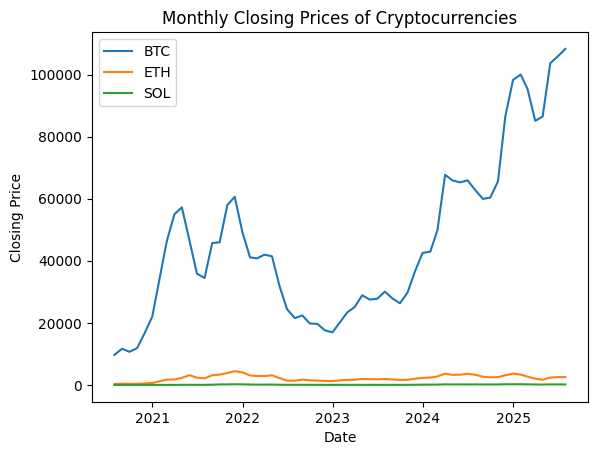

In [117]:
# Plotting of Monthly Trends
import matplotlib.pyplot as plt
import seaborn as sns   

for coin in coins:
    sns.lineplot(data=monthly[monthly['symbol'] == coin], x='Date', y='Close', label=coin)
plt.title('Monthly Closing Prices of Cryptocurrencies')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

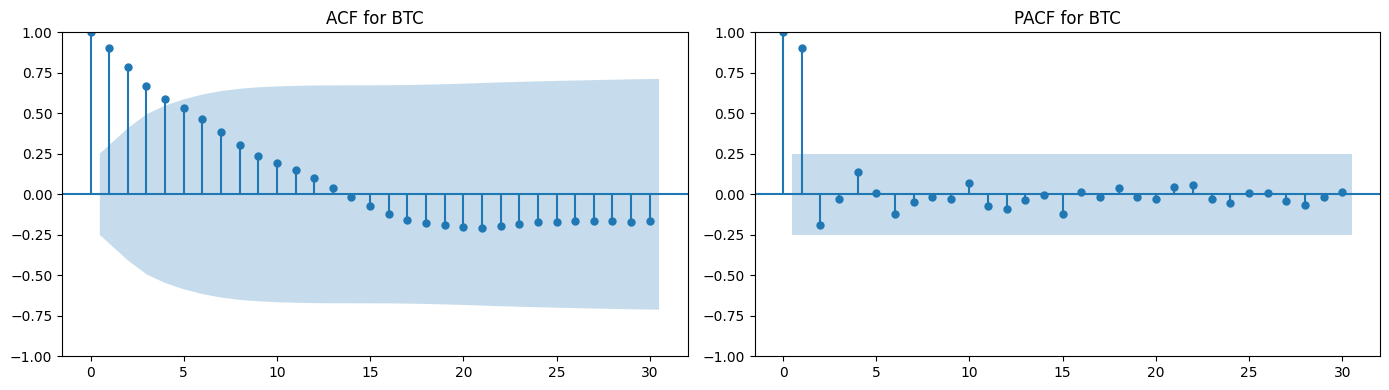

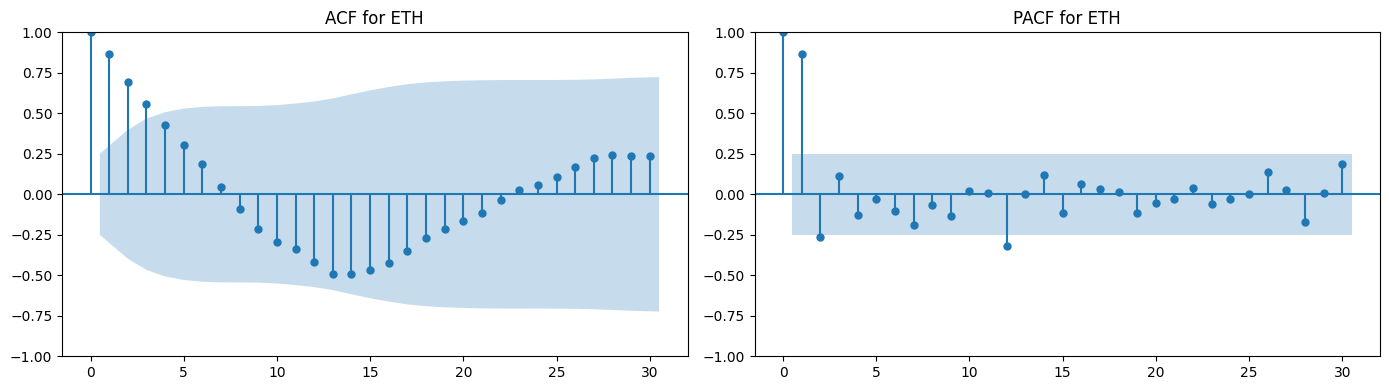

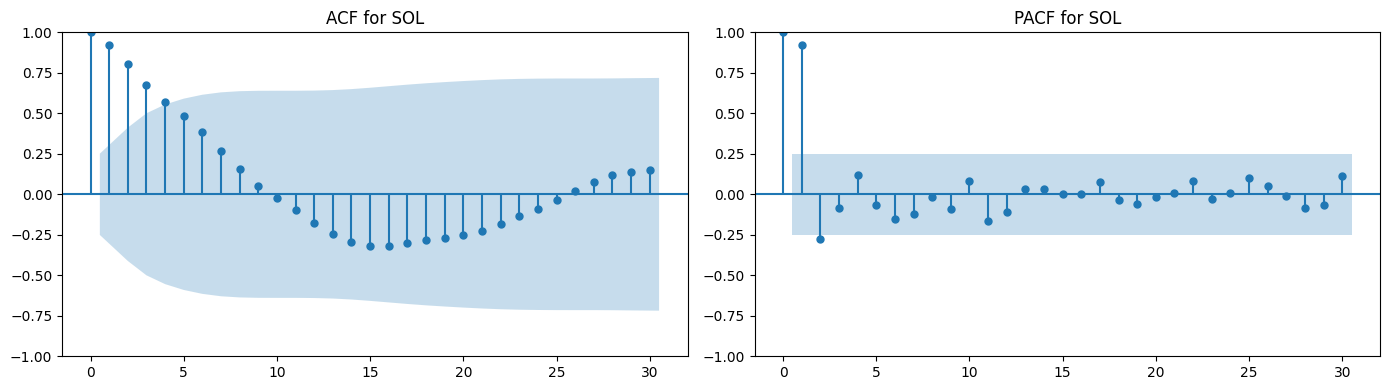

In [118]:
#Autocorrelation: Using ACF and PACF plots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

for coin in coins:
    fig, axes = plt.subplots(1, 2, figsize=(14, 4))  # 1 row, 2 columns
    coin_data = monthly[monthly['symbol'] == coin]['Close']
    plot_acf(coin_data, lags=30, ax=axes[0])
    axes[0].set_title(f'ACF for {coin}')
    plot_pacf(coin_data, lags=30, ax=axes[1])
    axes[1].set_title(f'PACF for {coin}')
    plt.tight_layout()
    plt.show()

3. Hyothesis Testing

In [119]:
# Checking for stationarity using Augmented Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller
def adf_test(series):
    result = adfuller(series)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    if result[1] <= 0.05:
        print("Reject the null hypothesis - The series is stationary")
    else:
        print("Fail to reject the null hypothesis - The series is non-stationary(try differencing)")
for coin in coins:
    adf_test(monthly[monthly['symbol'] == coin]['Close'])

ADF Statistic: -0.41816785181093763
p-value: 0.907020918889297
Fail to reject the null hypothesis - The series is non-stationary(try differencing)
ADF Statistic: -3.6207266699489042
p-value: 0.005376919896601149
Reject the null hypothesis - The series is stationary
ADF Statistic: -1.9580609573758947
p-value: 0.3052590642115779
Fail to reject the null hypothesis - The series is non-stationary(try differencing)


In [120]:
# Differencing the series to make it stationary

from statsmodels.tsa.stattools import adfuller

# Identify non-stationary coins based on p-value >= 0.05
non_stationary_coins = []
for coin in coins:
    pval = adfuller(monthly[monthly['symbol'] == coin]['Close'])[1]
    print(f"{coin} ADF p-value: {pval}")
    if pval >= 0.05:
        non_stationary_coins.append(coin)

# Create a copy to store differenced values
monthly_diff = monthly.copy()

# Perform first-order differencing for non-stationary coins
for coin in non_stationary_coins:
    mask = monthly_diff['symbol'] == coin
    monthly_diff.loc[mask, 'Close_diff'] = monthly_diff.loc[mask, 'Close'].diff()


BTC ADF p-value: 0.907020918889297
ETH ADF p-value: 0.005376919896601149
SOL ADF p-value: 0.3052590642115779


In [121]:
# Recheck stationarity after differencing
for coin in non_stationary_coins:
    diff_series = monthly_diff.loc[monthly_diff['symbol'] == coin, 'Close_diff'].dropna()
    result = adfuller(diff_series)
    print(f"{coin} after differencing:")
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    if result[1] <= 0.05:
        print("=> The differenced series is stationary.\n")
    else:
        print("=> The differenced series is still non-stationary.\n")

BTC after differencing:
ADF Statistic: -5.489555916574253
p-value: 2.190854959800705e-06
=> The differenced series is stationary.

SOL after differencing:
ADF Statistic: -5.603246387208629
p-value: 1.250850677954791e-06
=> The differenced series is stationary.



4. Modelling

In [122]:
# ARIMA
from pmdarima import auto_arima
btc = monthly[monthly['symbol']== 'BTC'].set_index('Date')['Close']

model = auto_arima(btc, seasonal=False, stepwise=True, trace=True)
print(model.summary())

# Forecasting with ARIMA
forecast = model.predict(n_periods=12)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1222.309, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1232.092, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1222.835, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1218.659, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1233.566, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1220.575, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1220.899, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1222.168, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1218.357, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1220.123, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=1220.005, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1222.092, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=1220.489, Time=0.08 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.411 seconds
                      

In [123]:
#SARIMA (Seasonal ARIMA)
from statsmodels.tsa.statespace.sarimax import SARIMAX
# Fit SARIMA model
sarima_model = SARIMAX(btc, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_results = sarima_model.fit(disp=False)
# Summary of SARIMA model
print(sarima_results.summary())
# Forecasting with SARIMA
sarima_forecast = sarima_results.get_forecast(steps=12)

                                     SARIMAX Results                                      
Dep. Variable:                              Close   No. Observations:                   61
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -493.477
Date:                            Mon, 07 Jul 2025   AIC                            996.954
Time:                                    22:49:06   BIC                           1006.310
Sample:                                07-31-2020   HQIC                          1000.489
                                     - 07-31-2025                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0246      0.487     -0.050      0.960      -0.978       0.929
ma.L1          0.4754      0.391   

22:49:06 - cmdstanpy - INFO - Chain [1] start processing
22:49:06 - cmdstanpy - INFO - Chain [1] done processing


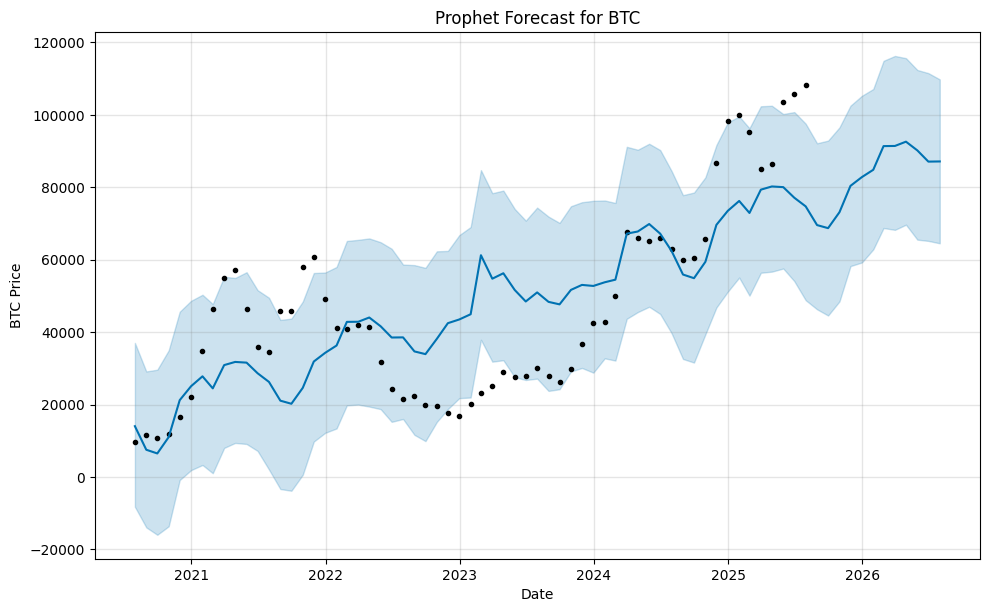

In [124]:
# Prophet
from prophet import Prophet

# Prepare data for Prophet
btc_prophet = monthly[monthly['symbol'] == 'BTC'][['Date', 'Close']].rename(columns={'Date': 'ds', 'Close': 'y'})
btc_prophet['ds'] = pd.to_datetime(btc_prophet['ds'])

# Initialize and fit the Prophet model
prophet_model = Prophet()
prophet_model.fit(btc_prophet)

# Create future dates for forecasting
future = prophet_model.make_future_dataframe(periods=12, freq='M')

# Forecast using Prophet
prophet_forecast = prophet_model.predict(future)

# Plotting Prophet forecast
fig = prophet_model.plot(prophet_forecast)
plt.title('Prophet Forecast for BTC')
plt.xlabel('Date')
plt.ylabel('BTC Price')
plt.show()


🔧 Processing BTC...
✅ BTC - MAE: 23410.33, MSE: 695786448.85, MAPE: 24.92%


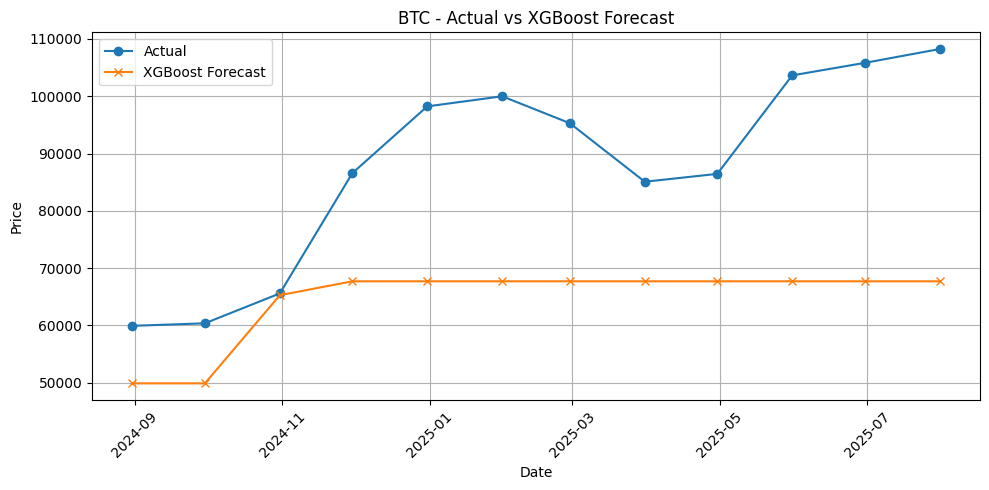


🔧 Processing ETH...
✅ ETH - MAE: 137.47, MSE: 31742.37, MAPE: 5.16%


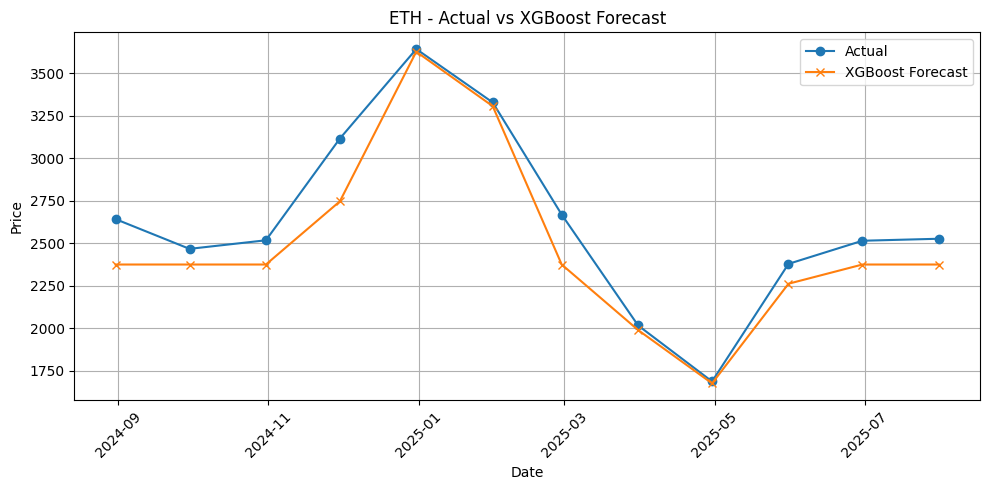


🔧 Processing SOL...
✅ SOL - MAE: 28.36, MSE: 1125.28, MAPE: 16.78%


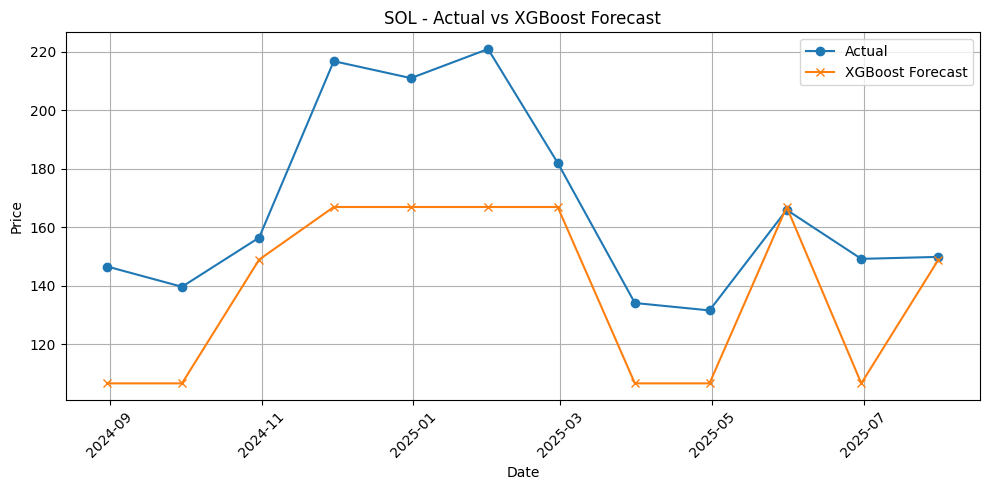


📊 Evaluation Summary:
  Symbol           MAE           MSE   MAPE (%)
0    BTC  23410.333761  6.957864e+08  24.922919
1    ETH    137.472150  3.174237e+04   5.163187
2    SOL     28.364670  1.125275e+03  16.783417


In [125]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split

# ---- Load and prepare the data ----
def prepare_lag_features(df, lags=30):
    df = df.copy()
    for i in range(1, lags + 1):
        df[f"lag_{i}"] = df['Close'].shift(i)
    df = df.dropna()
    return df

def run_xgboost_pipeline(crypto_symbol, data, lags=30):
    print(f"\n🔧 Processing {crypto_symbol}...")

    # Filter and process
    crypto_df = data[data['symbol'] == crypto_symbol].copy()
    crypto_df['Date'] = pd.to_datetime(crypto_df['Date'])
    crypto_df.set_index('Date', inplace=True)
    crypto_df = prepare_lag_features(crypto_df, lags)

    # Features and target
    X = crypto_df.drop(columns=['symbol', 'Close'])
    y = crypto_df['Close']

    # Train-test split (last 12 for testing)
    X_train, X_test = X[:-12], X[-12:]
    y_train, y_test = y[:-12], y[-12:]

    # Train XGBoost
    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=300, learning_rate=0.05)
    model.fit(X_train, y_train)

    # Predict
    preds = model.predict(X_test)

    # Evaluation
    mae = mean_absolute_error(y_test, preds)
    mse = mean_squared_error(y_test, preds)
    mape = np.mean(np.abs((y_test - preds) / np.clip(y_test, 1e-8, None))) * 100

    print(f"✅ {crypto_symbol} - MAE: {mae:.2f}, MSE: {mse:.2f}, MAPE: {mape:.2f}%")

    # Plot results
    plt.figure(figsize=(10, 5))
    plt.plot(y_test.index, y_test.values, label="Actual", marker='o')
    plt.plot(y_test.index, preds, label="XGBoost Forecast", marker='x')
    plt.title(f"{crypto_symbol} - Actual vs XGBoost Forecast")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return {
        "Symbol": crypto_symbol,
        "MAE": mae,
        "MSE": mse,
        "MAPE (%)": mape
    }

# --- Run for all cryptocurrencies ---
crypto_symbols = ['BTC', 'ETH', 'SOL']
all_results = []

for symbol in crypto_symbols:
    result = run_xgboost_pipeline(symbol, monthly, lags=30)
    all_results.append(result)

# --- Final results summary ---
results_df = pd.DataFrame(all_results)
print("\n📊 Evaluation Summary:")
print(results_df)


5. Model Evaluation

In [127]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pandas as pd
import numpy as np

plophet_forecast = prophet_forecast[-12:]
btc_prices = btc['Close'].values[-12:]

# Evaluation function
def evaluate_model(name, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / np.clip(y_true, 1e-8, None))) * 100
    return {"Model": name, "MAE": mae, "MSE": mse, "MAPE (%)": mape}

# Store results
results = []
results.append(evaluate_model("Prophet", btc_prices, plophet_forecast))
results.append(evaluate_model("SARIMA", btc_prices, sarima_forecast.predicted_mean.values))
results.append(evaluate_model("ARIMA", btc_prices, forecast))

# Convert to DataFrame
results_df = pd.DataFrame(results)
print(results_df)
# Plotting the results
import matplotlib.pyplot as plt
for index, row in results_df.iterrows():
    plt.bar(row['Model'], row['MAE'], label='MAE')
    plt.bar(row['Model'], row['MSE'], label='MSE', bottom=row['MAE'])
    plt.bar(row['Model'], row['MAPE (%)'], label='MAPE (%)', bottom=row['MAE'] + row['MSE'])
plt.title('Model Evaluation Metrics')
plt.xlabel('Models')
plt.ylabel('Error')
plt.legend()
plt.show()

KeyError: 'Close'

6. Model Comparison

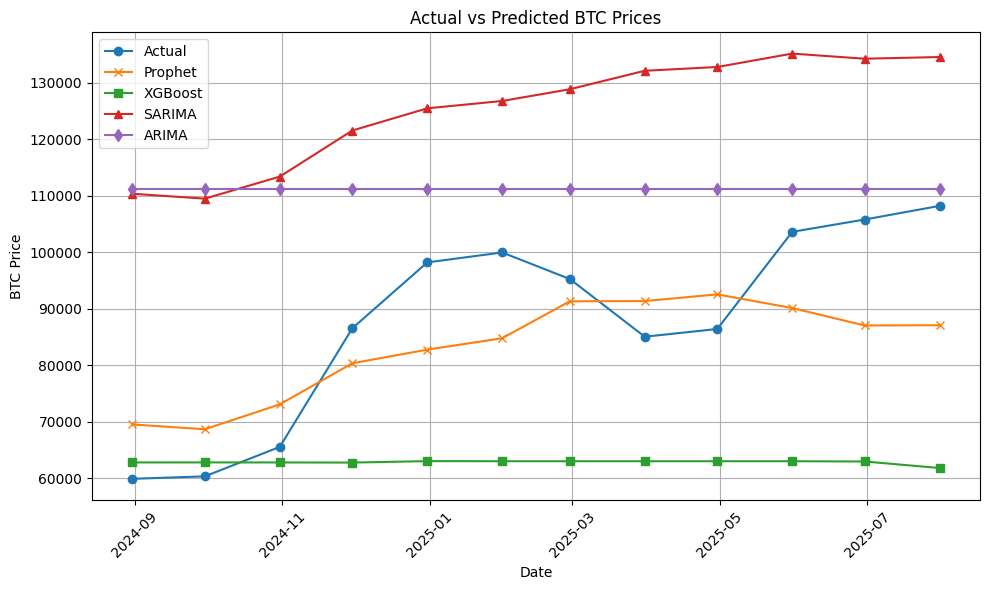

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(btc.index[-12:], btc_prices, label='Actual', marker='o')
plt.plot(btc.index[-12:], prophet_forecast, label='Prophet', marker='x')
plt.plot(btc.index[-12:], xgb_forecast, label='XGBoost', marker='s')
plt.plot(btc.index[-12:], sarima_forecast.predicted_mean.values, label='SARIMA', marker='^')
plt.plot(btc.index[-12:], forecast, label='ARIMA', marker='d')
plt.xlabel('Date')
plt.ylabel('BTC Price')
plt.title('Actual vs Predicted BTC Prices')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()